## Imports

In [1]:
import cv2
import numpy as np
import mediapipe as mp
from numpy import save
import math as m
import matplotlib.pyplot as plt
import os
from scipy.io import savemat
import scipy.io
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy import signal
from scipy import stats
from numpy import moveaxis
from numpy import asarray
import torch
from scipy.stats import multivariate_normal
import torchvision
from torch.linalg import multi_dot
from HyperParameters import *
from Functions import *
from matplotlib import cm


## Read data

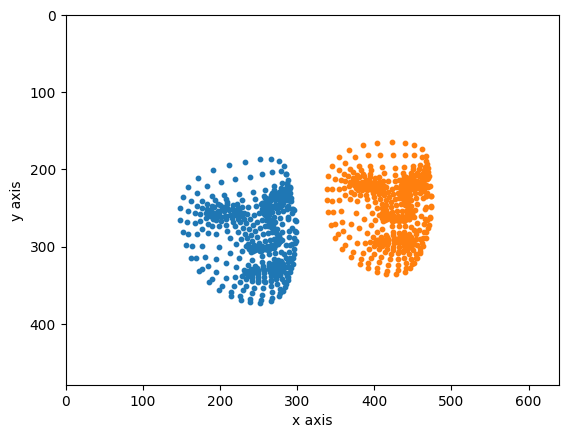

In [2]:
imgRef = torchvision.io.read_image(PathImg1)
imgTar = torchvision.io.read_image(PathImg2)

refKey = torch.tensor(np.load(PathNPY1), device=DEVICE)
tarKey = torch.tensor(np.load(PathNPY2), device=DEVICE)

height, width = imgRef.shape[1], imgRef.shape[2]
draw(width, height, refKey, tarKey, size=10, connect=False)

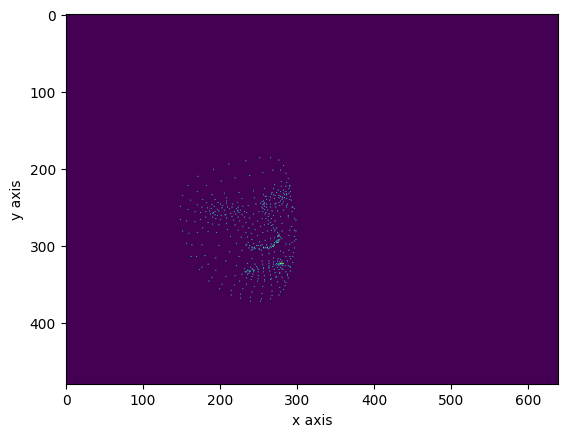

In [7]:
a = createMask(refKey, height, width)
showImageTensor(a, is3chan=False)

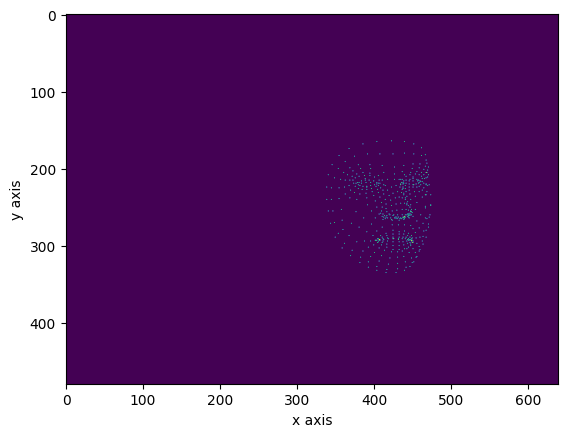

In [8]:
a = createMask(tarKey, height, width)
showImageTensor(a, is3chan=False)

## Transform data

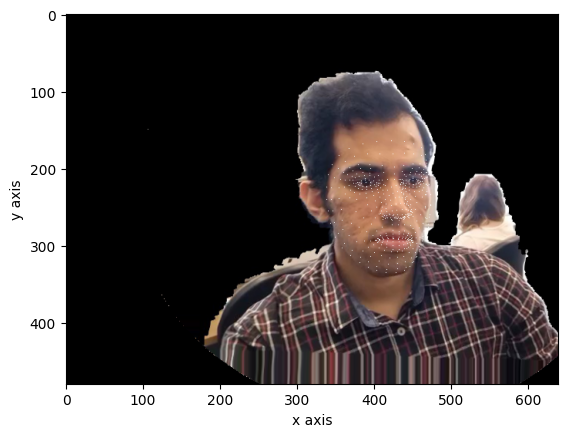

In [9]:
output = RenderImage(height, width, refKey, tarKey, imgRef, sd=0.01)

dummy = torch.squeeze(output)
dummy = createMask(tarKey, height, width, dummy).int()

img = showImageTensor(dummy, is3chan=True, isOutput=True, returnOutput=True)
# showImageTensor(output.int(), is3chan=True, isOutput=True)
# showImageTensor(output, isOutput=True)

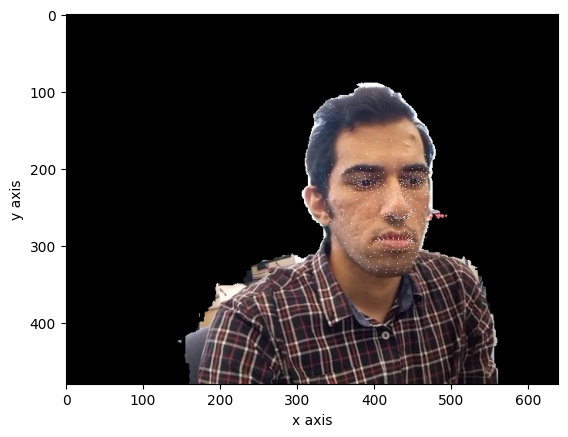

In [7]:
mm = createMask(tarKey, height, width, imgTar)
showImageTensor(mm, is3chan=True)

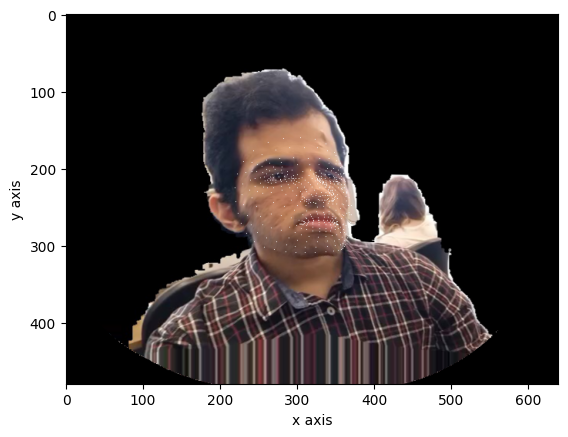

In [8]:
frameSize = (640, 480)

out = cv2.VideoWriter('rotation-X.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 10, frameSize)

i = 0
j = 0
k = 0
T = -torch.mean(refKey, axis=0) + torch.tensor([0.5, 0.5, 0], device=DEVICE)
# T = torch.tensor([0, 0, 0], device=DEVICE)

for i in range(-45, 45):
  euler = torch.tensor([i * pi/180, j * pi/180, k * pi/180], device=DEVICE)
  newKeys = TransformKeys(refKey, euler, T)
  output = RenderImage(height, width, refKey, newKeys, imgRef, sd=0.01, distMethod="gaussian")

  dummy = torch.squeeze(output)
  dummy = createMask(newKeys, height, width, dummy).int()
  
  img = showImageTensor(dummy, is3chan=True, isOutput=True, returnOutput=True)
  img = np.moveaxis(np.uint8(img), 0, -1)
  out.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


out.release()

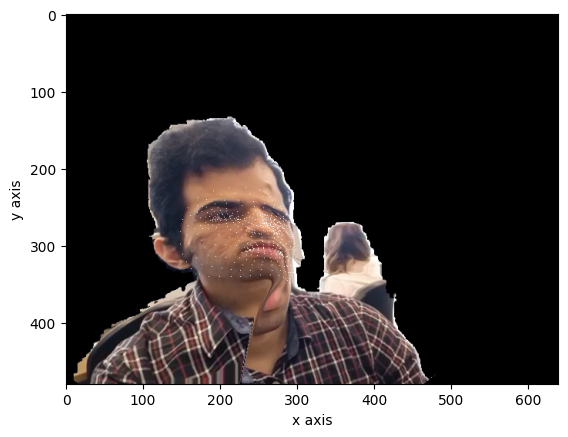

In [9]:
# T = -torch.mean(refKey, axis=0) + torch.tensor([0.5, 0.5, 0], device=DEVICE) #+ torch.tensor([-0.3, 0.3, 0], device=DEVICE)
T = torch.tensor([0, 0, 0], device=DEVICE)

euler = torch.tensor([pi/3, 0, 0], device=DEVICE)
newKeys = TransformKeys(refKey, euler, T)
output = RenderImage(height, width, refKey, newKeys, imgRef)

dummy = torch.squeeze(output)
dummy = createMask(newKeys, height, width, dummy).int()

img = showImageTensor(dummy, is3chan=True, isOutput=True, returnOutput=True)


## Webcam

In [5]:

# For webcam input:
cap = cv2.VideoCapture(0)
with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as face_mesh:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image)

    # Draw the face mesh annotations on the image.
    image.flags.writeable = True
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_face_landmarks:
      LandMarks = np.zeros((FACE_LANKMARK_LENGTH, 3))
      for i, land in enumerate(results.multi_face_landmarks[0].landmark):
  
        LandMarks[i] = [land.x, land.y, land.z]
       
      landTen = torch.tensor(LandMarks, device=DEVICE)
      ##
      output = RenderImage(height, width, refKey, landTen, imgRef, sd=0.01)

      dummy = torch.squeeze(output)
      # dummy = createMask(landTen, height, width, dummy).int()
      image =  (dummy.cpu().permute(1, 2, 0).numpy()).astype(np.uint8)
      #img = showImageTensor(dummy, is3chan=True, isOutput=True, returnOutput=True)
# showImageTensor(output.int(), is3chan=True, isOutput=True)
# showImageTensor(output, isOutput=True)


      # cv2.imshow('MediaPipe Face Mesh', cv2.flip(image, 1))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imshow('MediaPipe Face Mesh', image)
    if cv2.waitKey(5) & 0xFF == ord('q'):
      break
cap.release()
cv2.destroyAllWindows()

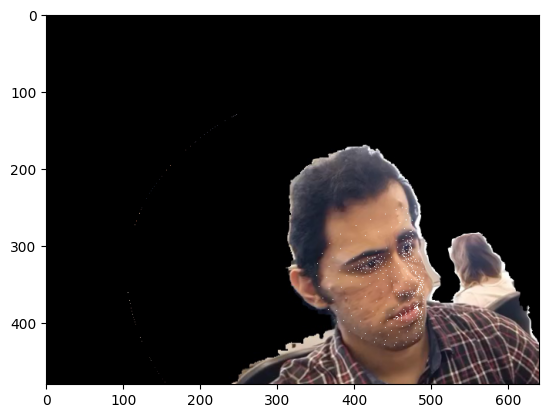

In [40]:
plt.imshow(newImg)

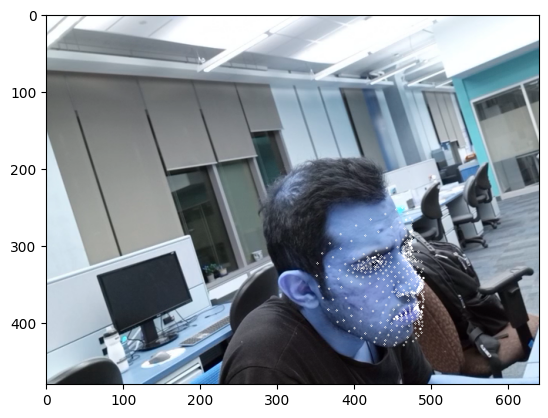

In [41]:
plt.imshow(image)

In [82]:
height

480